In [1]:
import numpy as np
import scipy.stats as sps
import scipy.optimize as spo

import matplotlib.pyplot as plt

Случайный датасет. Точки, лежащие на прямой $y = 0.5x + 2$ со нормально распределённой случайной ошибкой.

In [2]:
A = 0.5
B = 2.0
n = 100

x = np.linspace(0,10, n)
y = A*x + B + np.random.normal(scale=.5, size=n)

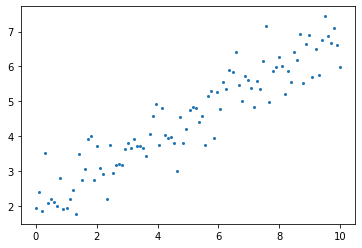

In [3]:
plt.scatter(x,y, s=4)

Линейная модель $y = ax+b$

In [4]:
def linear(x, a,b):
    return a*x+b

Подбор параметров линейной модели методом наименьших квадратов

In [5]:
((a,b), cov) = spo.curve_fit(linear, xdata=x, ydata=y)

In [6]:
a,b

(0.48131338327467227, 2.0807809838898876)

Случайная составляющая

In [7]:
u = y - (a*x+b)

In [8]:
u_mean, u_sigma = sps.norm.fit(u)

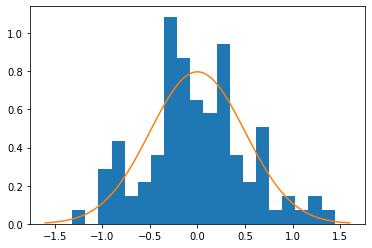

In [9]:
_u = np.linspace(u_mean - u_sigma*3, u_mean + u_sigma*3, 100)
plt.hist(u, bins=20, density=True)

plt.plot(_u, sps.norm(0, 0.5).pdf(_u))

Несмещенная оценка дисперсии случайного члена $u$ $\sigma_u^2 = \frac{1}{n-2}\sum({u_i^2 - \overline{u}^2})$

In [10]:
sigma_square = sps.sem(u, ddof=2)

 $nD[x] = \sum (x-\overline{x})^2$

In [32]:
dx_square = np.sum((x-np.mean(x))**2)

Дисперсия $a$: $D[a] = \frac{1}{n}\frac{\sigma_u^2}{D[x]}$

In [33]:
var_a = sigma_square/dx_square

Дисперсия $b$: $D[b] = \sigma_u^2\large[\frac{1}{n} + \frac{\overline{x}^2}{nD[x]}]$

In [37]:
# var_b = 1.0/n*np.mean(x*x)/var_x
var_b = sigma_square*(1.0/n + np.mean(x)**2/dx_square)

In [39]:
var_a, var_b

(6.33845030420234e-05, 0.002123487559825363)

Доверительный интервал для $a$ через $t$ распределение Стьюдента с уровнем ошибки $\alpha = 0.05$

In [44]:
conf_a = sps.t.interval(0.95, df = n-2, loc=a, scale=np.sqrt(var_a))
conf_a

(0.4655141676744295, 0.49711259887491505)

Доверительный интервал для $b$ через $t$ распределение Стьюдента с уровнем ошибки $\alpha = 0.05$

In [45]:
conf_b = sps.t.interval(0.95, df = n-2, loc = b, scale = np.sqrt(var_b))
conf_b

(1.9893341147107775, 2.172227853068998)

График линейных моделей, соответствующих крайним точкам доверительных интервалов

In [17]:
def mk_model(a,b):
    return lambda x: linear(x, a,b)

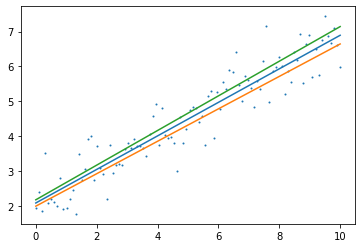

In [42]:
plt.scatter(x, y, s=1)
plt.plot(x, mk_model(a,b)(x))
plt.plot(x, mk_model(conf_a[0], conf_b[0])(x))
plt.plot(x, mk_model(conf_a[1], conf_b[1])(x))